In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

sys.path.append('../../Surrogate_Model/')
from surrogate_model_training_data import get_data

In [12]:
%matplotlib notebook

In [2]:
from go_mpc import go_mpc

In [3]:
gmpc = go_mpc(n_horizon=10)

----------------------------------------------------
Loaded Keras model with the following architecture:
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                3760      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 42)                3402      
Total params: 20,122
Trainable params: 20,122
Non-trainable params: 0
_________________________________________________________________
None
-----------

# Get network informations

In [4]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
nn_model_path = './model/002_man_4x80/'
cluster_labels = pd.read_json(nn_model_path+'cluster_labels_dt1h.json')
pressure_factor = pd.read_json(nn_model_path+'pressure_factor_dt1h.json')

Get results:

In [6]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_14.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [49]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()
junction_pressure = results.node['pressure'][node_names[2]]

In [50]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

# Physical pressure
jun_cl_press_min = junction_pressure.groupby(cluster_labels.loc['pressure_cluster'], axis=1).min()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

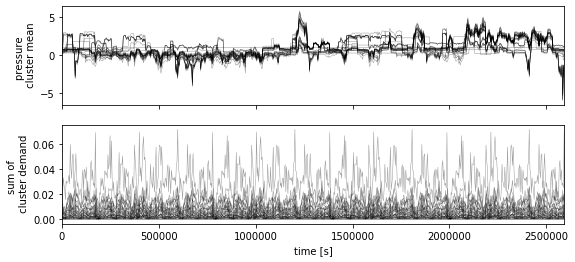

In [9]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

### Tanks

In [10]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

### Pumps

In [14]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

In [15]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000

### Valves

In [16]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

## Neural Network Pre-Processing
### States and Inputs

In [17]:
state_dict = {'tank_press': tank_press}



input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle}

tvp_dict = {'jun_cl_demand_sum': jun_cl_demand_sum}
              
sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())
sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())
sys_tvp = pd.concat(tvp_dict.values(), axis=1, keys=tvp_dict.keys())

# Evaluate Casadi Function

In [18]:
x_next_fun = gmpc.x_next_fun
nlcons_fun = gmpc.nl_cons_fun

In [19]:
x_num = gmpc.x(0)
u_num = gmpc.u(0)
tvp_num = gmpc.tvp(0)
p_set_num = gmpc.p_set(0)

In [38]:
x0 = tank_press.loc[0].to_numpy().reshape(-1,1)
x = [x0]
p_min = []

k_end = len(tank_press)
for k in range(k_end):
    u_now = sys_inputs.iloc[k].to_numpy()
    tvp_now = sys_tvp.iloc[k].to_numpy
    x_num['tank_press'] = x[k]
    u_num['head_pump'] = head_pump_speed_corr.iloc[k].to_numpy()
    u_num['PRValve'] = PRValve_dp.iloc[k].to_numpy()
    u_num['TCValve'] = TCValve_throttle.iloc[k].to_numpy()
    tvp_num['jun_cl_demand_sum'] = jun_cl_demand_sum.iloc[k].to_numpy()
    x_next = gmpc.x_next_fun(x_num, u_num, tvp_num, p_set_num)
    nl_cons = gmpc.nl_cons(gmpc.nl_cons_fun(x_num, u_num, tvp_num, p_set_num))
    p_min.append(nl_cons['jun_cl_press_min'])
    x.append(x_next)
 
x = np.concatenate(x, axis=1).T
p_min = np.concatenate(p_min, axis=1).T

In [43]:
tank_level_calc = pd.DataFrame(x[:-1,:], columns=tank_press.columns, index=tank_press.head(k_end).index)
jun_cl_press_min_calc = pd.DataFrame(p_min, index=tank_press.head(k_end).index)

<IPython.core.display.Javascript object>


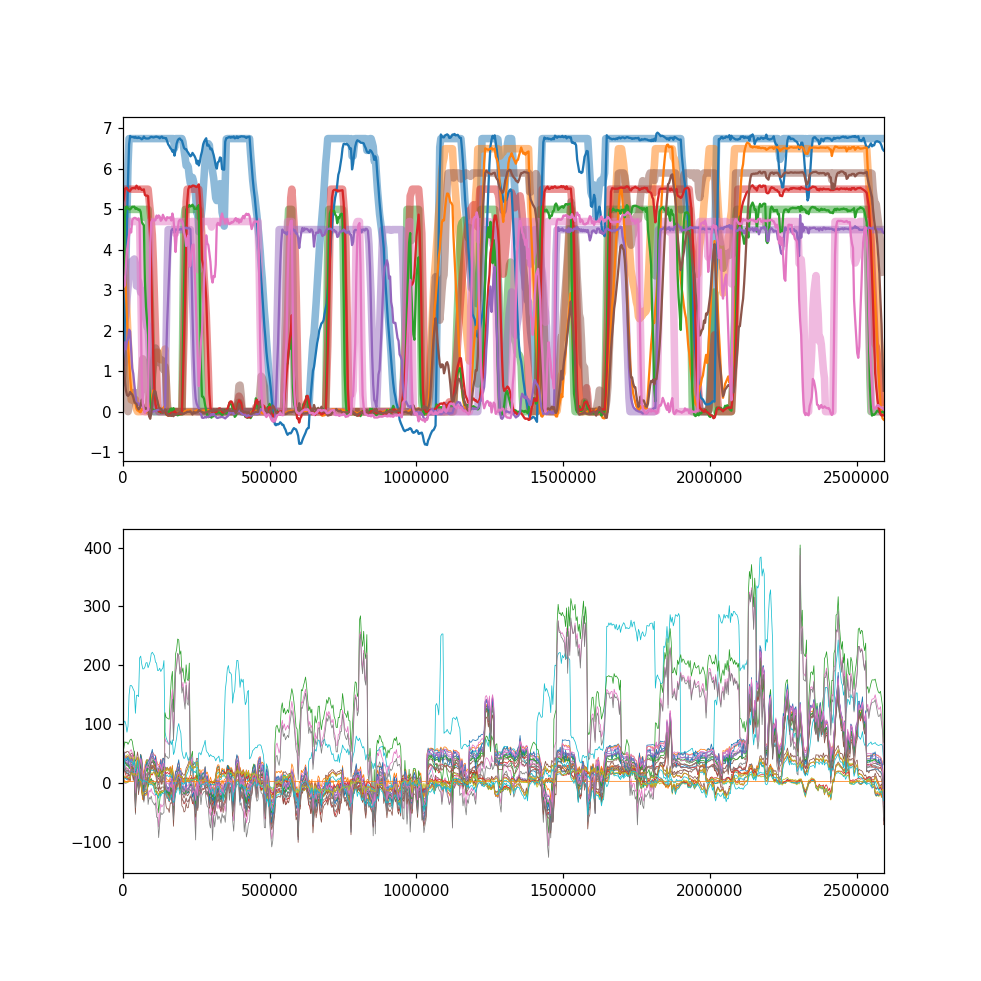

In [55]:
fig, ax = plt.subplots(2,1,figsize=(9,9))
tank_level.plot(legend=False, ax=ax[0], linewidth=5, alpha=0.5)
ax[0].set_prop_cycle(None)
tank_level_calc.plot(legend=False, ax=ax[0])

#jun_cl_press_min.plot(legend=False, ax=ax[1], linewidth=1, alpha=0.3)
ax[1].set_prop_cycle(None)
jun_cl_press_min_calc.plot(legend=False, ax=ax[1], linewidth=0.5)
